In [41]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import mahalanobis
import scipy
import imblearn
from imblearn.over_sampling import SMOTE
from scipy import stats
import math

In [31]:
%store -r xgb_model
%store -r filtered_trainDF

In [32]:
# Prepare the data: Define features (X) and target (y)
X = filtered_trainDF.drop(columns=['isFraud'])  # Features (drop the target column)
y = filtered_trainDF['isFraud']  # Target

# Handle Timestamp columns (convert them to numeric if necessary)
for col in X.columns:
    if X[col].dtype == 'datetime64[ns]' or 'Timestamp' in str(X[col].dtype):
        X[col] = X[col].astype('int64')  # Convert datetime to int (timestamps)

# Convert categorical columns to numeric using Label Encoding (for simplicity)
label_encoders = {}
for column in X.columns:
    if X[column].dtype == 'object' or isinstance(X[column].dtype, pd.CategoricalDtype):
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column].astype(str))
        label_encoders[column] = le

# Replace infinite or very large values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values for numeric columns with column mean, and categorical columns with mode
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:  # For numeric columns
        X[col] = X[col].fillna(X[col].mean())  # Assign the filled result back to the column
    else:  # For categorical columns, fill with the most frequent value
        X[col] = X[col].fillna(X[col].mode()[0])  # Assign the filled result back to the column
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------------------------------------------------------------------

# Grid Search Best Estimator Analysis

In [34]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1],
    'subsample': [0.8, 1.0]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

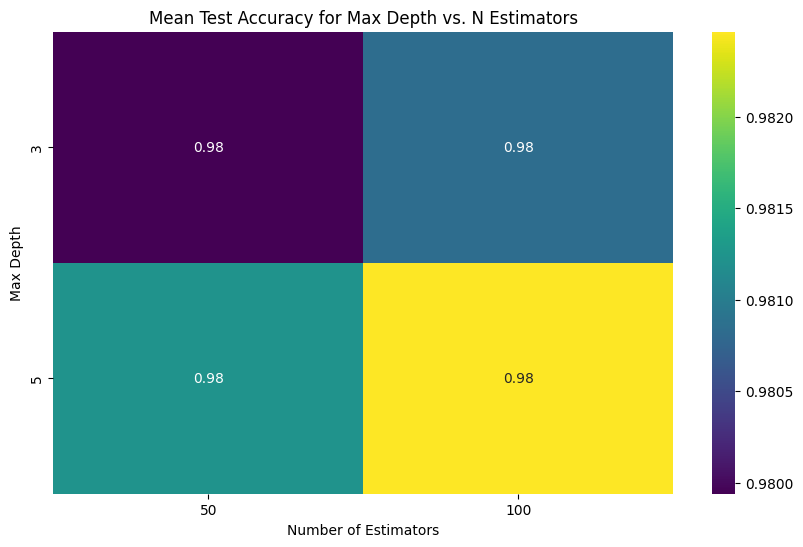

In [37]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot the data for a heatmap (example for 'max_depth' vs 'n_estimators')
pivot_table = results_df.pivot_table(values='mean_test_score', 
                                     index='param_max_depth', 
                                     columns='param_n_estimators')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Mean Test Accuracy for Max Depth vs. N Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()

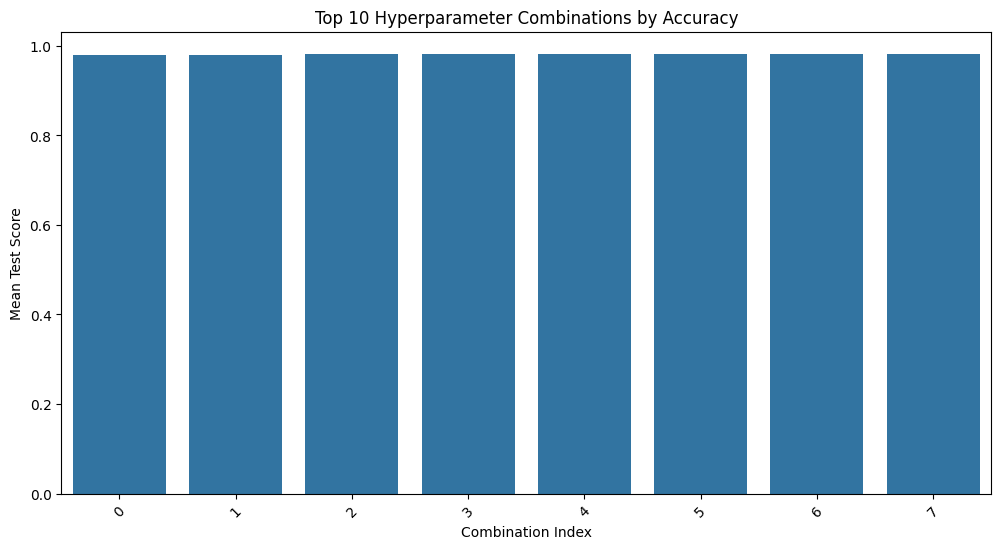

In [38]:
top_results = results_df.sort_values(by='mean_test_score', ascending=False).head(10)

# Plot a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_results.index, y=top_results['mean_test_score'])
plt.title('Top 10 Hyperparameter Combinations by Accuracy')
plt.ylabel('Mean Test Score')
plt.xlabel('Combination Index')
plt.xticks(rotation=45)
plt.show()

# --------------------------------------------------------------------------------------

In [35]:
top_n = 10
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(top_n).index

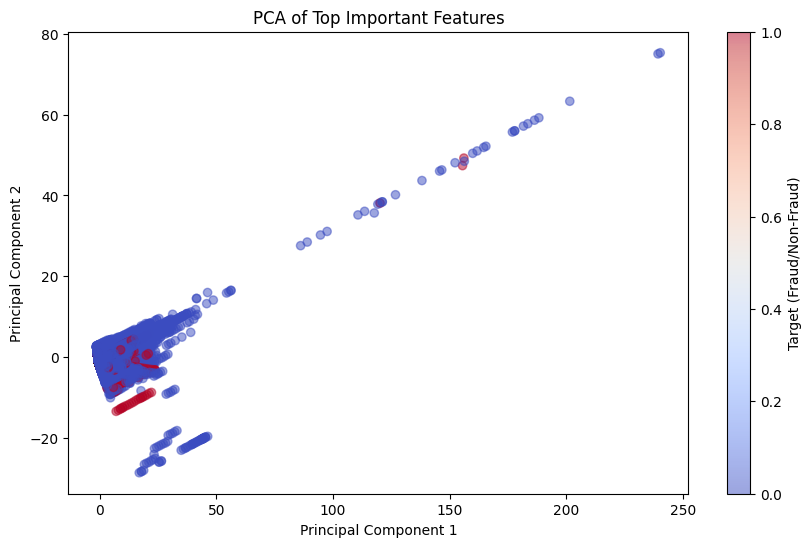

In [36]:
X_reduced = X[top_features]
pca = PCA(n_components=2)  # Change the number of components as needed
X_pca = pca.fit_transform(X_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Top Important Features')
plt.colorbar(label='Target (Fraud/Non-Fraud)')
plt.show()

In [39]:
X_train_top_features = X_train[top_features]
X_test_top_features = X_test[top_features]
grid_search_top_features = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search_top_features.fit(X_train_top_features, y_train)

best_model_top_features = grid_search_top_features.best_estimator_
y_pred = best_model_top_features.predict(X_test_top_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the tuned model using top 10 features: {accuracy:.4f}")

Accuracy of the tuned model using top 10 features: 0.9799


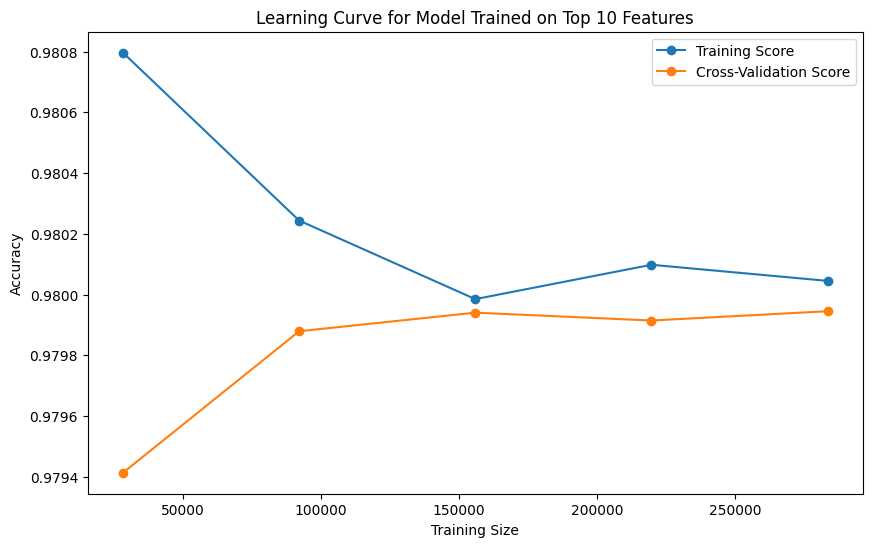

In [42]:
train_sizes, train_scores, test_scores = learning_curve(best_model_top_features, 
                                                        X_train_top_features, 
                                                        y_train, cv=3, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label='Cross-Validation Score')
plt.title('Learning Curve for Model Trained on Top 10 Features')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()